In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from datetime import timedelta
from datetime import datetime as dt
from o2_vix import get_indiv_fomc, plot_indiv_fomc, get_cs_avg_new, plot_cs_avg, get_panel_bucket
os.chdir("C:/Users/zheng/Documents/Finance Research/")
plt.style.use('ggplot')
palette = sns.color_palette("husl", 3)

## Loading

In [2]:
os.chdir("C:/Users/zheng/Documents/Finance Research/")
event_df = pd.read_csv("Data/macro/data/macro/macro_announcement_dates_202112.csv")
for col in event_df.columns:
    event_df[col] = pd.to_datetime(event_df[col], format="%m/%d/%Y")
event_df.head()

,Unemployment Rate,Consumer Price Index,Producer Price Index,CFNAI,EIA,OPEC,IEA,Old_FOMC,New_FOMC,GDP Annualized Advanced,...,Factory Orders,New Home Sales,Personal Consumption,Monthly Budget Statement,Initial Jobless Claims,Chicago Purchasing Manager Index,U. Michigan Consumer Confidence P,U. Michigan Consumer Confidence F,Actual fed funds target rate FFTR,Inflation
0,1957-07-11,1953-02-27,1971-02-17,2001-03-05,2001-05-23,2001-01-19,1991-01-01,1936-03-19,1994-02-04,1968-01-16,...,1990-01-05,1990-01-03,1990-01-29,1990-02-22,1991-07-18,1996-11-27,1991-01-18,1991-02-01,1990-02-07,1980-02-15
1,1957-08-12,1953-03-26,1971-03-05,2001-04-03,2001-05-31,2001-02-20,1991-02-01,1936-05-25,1994-03-22,1968-04-17,...,1990-02-02,1990-01-31,1990-03-01,1990-03-21,1991-07-25,1996-12-31,1991-02-15,1991-03-01,1990-03-27,1980-03-07
2,1957-09-10,1953-04-22,1971-04-01,2001-05-02,2001-06-06,2001-03-22,1991-04-01,1936-11-20,1994-05-17,1968-07-18,...,1990-03-07,1990-03-02,1990-03-29,1990-04-20,1991-08-01,1997-01-31,1991-03-15,1991-03-29,1990-05-15,1980-04-04
3,1957-10-10,1953-05-22,1971-05-06,2001-05-31,2001-06-13,2001-04-20,1991-05-01,1937-01-26,1994-07-06,1968-10-16,...,1990-03-30,1990-03-28,1990-04-30,1990-05-21,1991-08-08,1997-02-28,1991-04-19,1991-05-03,1990-07-03,1980-05-09
4,1957-11-08,1953-06-23,1971-06-04,2001-07-05,2001-06-20,2001-05-17,1991-07-03,1937-03-15,1994-08-16,1969-01-14,...,1990-05-02,1990-04-30,1990-05-25,1990-06-21,1991-08-15,1997-03-31,1991-05-17,1991-05-31,1990-08-21,1980-06-06


In [3]:
fomc_pc = pd.read_excel('Data/macro/data/macro/fomc_scheduled_date_time_2.xlsx')
fomc_pc['Datetime'] = pd.to_datetime(fomc_pc['OfficialTime'], format="%Y-%m-d %H:%M:%S.%f")
fomc_pc['Datetime'] =  fomc_pc['Datetime'].apply(lambda t: t.replace(hour=14,minute=0,second=0))
fomc_pc.drop('OfficialTime', axis=1, inplace=True)
fomc_pc.set_index('Datetime', inplace=True)
fomc_pc.head()

,PC
Datetime,
1997-09-30 14:00:00,0
1997-11-12 14:00:00,0
1997-12-16 14:00:00,0
1998-02-04 14:00:00,0
1998-03-31 14:00:00,0


In [4]:
fomc_pcT = fomc_pc[fomc_pc['PC'] == 1]
fomc_pcF = fomc_pc[fomc_pc['PC'] == 0]

In [5]:
fomc_pc.index[119]

Timestamp('2012-08-01 14:00:00')

In [6]:
fomc_pc.index[170]

Timestamp('2018-12-19 14:00:00')

In [7]:
fomc_pc.index[190]

Timestamp('2021-07-28 14:00:00')

In [8]:
fomc_pc_1218 = fomc_pc.loc['2012-01-01 14:00:00': '2019-01-01 14:00:00']
fomc_pc_1218T = fomc_pc_1218[fomc_pc_1218['PC'] == 1]
fomc_pc_1218F = fomc_pc_1218[fomc_pc_1218['PC'] == 0]
fomc_pc_1218T.head()

,PC
Datetime,
2012-01-25 14:00:00,1
2012-04-25 14:00:00,1
2012-06-20 14:00:00,1
2012-09-13 14:00:00,1
2012-12-12 14:00:00,1


In [9]:
fomc_pc_1218.head()

,PC
Datetime,
2012-01-25 14:00:00,1
2012-03-13 14:00:00,0
2012-04-25 14:00:00,1
2012-06-20 14:00:00,1
2012-08-01 14:00:00,0


In [10]:
vix_index = pd.read_csv("Data/vix_futures/data/vix_futures/IAP/IAP.csv")
vix_index["Datetime"] = pd.to_datetime(vix_index["Date"] + " " + vix_index["Time"], format="%m/%d/%Y %H:%M:%S.%f")
vix_index["Datetime"] = vix_index["Datetime"] + timedelta(hours=1) # Adjust time to ET
vix_index.set_index('Datetime', inplace=True)
vix_index.drop(['Date', 'Time'], axis = 1, inplace=True)
vix_index = vix_index.between_time('9:00', '16:30')
vix_index.head()

,Price
Datetime,
2003-07-01 09:45:05,22.47
2003-07-01 09:46:05,22.46
2003-07-01 09:47:05,22.20
2003-07-01 09:48:05,22.44
2003-07-01 09:49:05,22.34


In [11]:
sp500 = pd.read_csv("Data/spy_ohlc_30min.csv")
sp500["Datetime"] = pd.to_datetime(sp500["Date"], format="%Y-%m-%d %H:%M")
sp500.set_index('Datetime', inplace=True)
sp500.drop(['Date', 'High', 'Low'], axis = 1, inplace=True)
sp500.sort_index(inplace=True)
sp500.head()

,Open,Close
Datetime,,
2008-01-02 09:30:00,1467.97,1469.37
2008-01-02 10:00:00,1467.11,1459.91
2008-01-02 10:30:00,1459.76,1456.92
2008-01-02 11:00:00,1457.00,1453.48
2008-01-02 11:30:00,1453.39,1452.49


In [12]:
fomc_datetimes = event_df['New_FOMC'] + pd.Timedelta(hours=14)
fomc_datetimes = list(fomc_datetimes.dropna())[148:]

## Cumilative changes, log returns and cross sectional averages

### 2012 to 2018 All FOMC

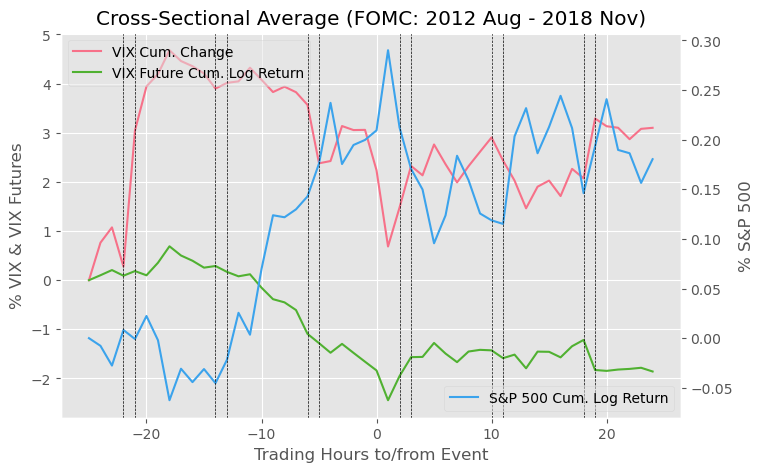

In [13]:
cs_avg_1218 = get_cs_avg_new(vix_index, sp500, list(fomc_pc_1218.index)[4:-1], fomc_pc, 1, 24, 'h')
plot_cs_avg(cs_avg_1218[1], 'Cross-Sectional Average (FOMC: 2012 Aug - 2018 Nov)')


In [14]:
test = pd.merge(cs_avg_1218[0][0], cs_avg_1218[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Price_x,Datetime Label_x,% Change,Cum. % Change,PC,Symbol,Open Time,Close Time,Price_y,Datetime Label_y,Log Price,Log Return %,Cum. Log Return %
Event Datetime,Datetime,,,,,,,,,,,,,


In [15]:
test = pd.merge(cs_avg_1218[0][1], cs_avg_1218[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


### 2012 - 2018 FOMC with PC

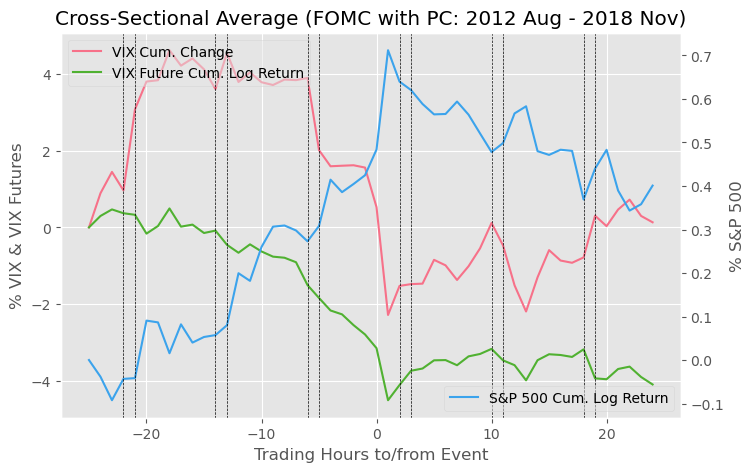

In [16]:
cs_avg_1218_pc = get_cs_avg_new(vix_index, sp500, list(fomc_pc_1218T.index)[3:-1], fomc_pc, 1, 24, 'h')
plot_cs_avg(cs_avg_1218_pc[1], 'Cross-Sectional Average (FOMC with PC: 2012 Aug - 2018 Nov)')

In [17]:
test = pd.merge(cs_avg_1218_pc[0][0], cs_avg_1218_pc[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Price_x,Datetime Label_x,% Change,Cum. % Change,PC,Symbol,Open Time,Close Time,Price_y,Datetime Label_y,Log Price,Log Return %,Cum. Log Return %
Event Datetime,Datetime,,,,,,,,,,,,,


In [18]:
test = pd.merge(cs_avg_1218_pc[0][1], cs_avg_1218_pc[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


### 2012 - 2018 FOMC without PC

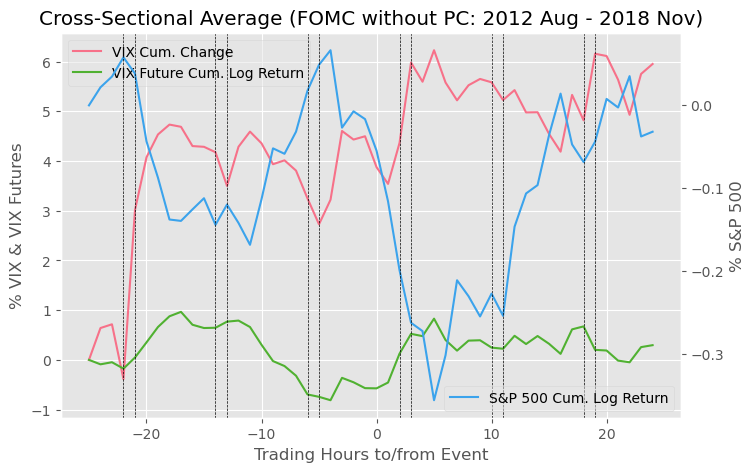

In [19]:
cs_avg_1218_nopc = get_cs_avg_new(vix_index, sp500, list(fomc_pc_1218F.index)[1:], fomc_pc, 1, 24, 'h')
plot_cs_avg(cs_avg_1218_nopc[1], 'Cross-Sectional Average (FOMC without PC: 2012 Aug - 2018 Nov)')

In [20]:
test = pd.merge(cs_avg_1218_nopc[0][0], cs_avg_1218_nopc[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Price_x,Datetime Label_x,% Change,Cum. % Change,PC,Symbol,Open Time,Close Time,Price_y,Datetime Label_y,Log Price,Log Return %,Cum. Log Return %
Event Datetime,Datetime,,,,,,,,,,,,,


In [21]:
test = pd.merge(cs_avg_1218_nopc[0][1], cs_avg_1218_nopc[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


### 2012 - 2021 all FOMC

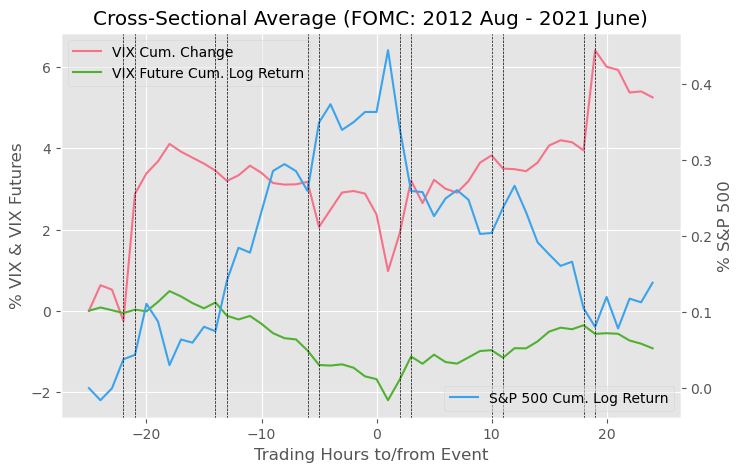

In [22]:
cs_avg_full = get_cs_avg_new(vix_index, sp500, list(fomc_pc.index)[119:170] + list(fomc_pc.index)[171:190], fomc_pc, 1, 24, 'h')
plot_cs_avg(cs_avg_full[1], 'Cross-Sectional Average (FOMC: 2012 Aug - 2021 June)')

In [ ]:
test = pd.merge(cs_avg_full[0][0], cs_avg_full[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Price_x,Datetime Label_x,% Change,Cum. % Change,PC,Symbol,Open Time,Close Time,Price_y,Datetime Label_y,Log Price,Log Return %,Cum. Log Return %
Event Datetime,Datetime,,,,,,,,,,,,,


In [ ]:
test = pd.merge(cs_avg_full[0][1], cs_avg_full[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


## Individual FOMC

### All

In [ ]:
indiv_fomc_all = get_indiv_fomc(fomc_datetimes[148:], vix_index, sp500, 24, 'h', 1)

In [ ]:
plot_indiv_fomc(indiv_fomc_all)

### Previous day fed watch odds > 0.25

In [ ]:
effr = pd.read_csv('Data/effr.csv')
effr['Effective Date'] = pd.to_datetime(effr['Effective Date'], format="%m/%d/%Y")
fwprob = pd.read_csv("Data/fw_prob.csv")
fwprob.drop('Unnamed: 0', axis=1, inplace=True)
fwprob['WatchDate'] = pd.to_datetime(fwprob['WatchDate'], format="%Y-%m-%d")
effr_fwprob = effr.merge(fwprob, how='left', left_on = 'Effective Date', right_on = 'WatchDate')
effr_fwprob = effr_fwprob.dropna(axis=1, how='all')
effr_fwprob = pd.concat([effr_fwprob[['Effective Date', 'Rate (%)', 'Target Rate From (%)', 'Target Rate To (%)']],
                  effr_fwprob.iloc[:, 15:]], axis=1)
effr_fwprob.set_index('Effective Date', inplace=True)
fomc_index = [effr_fwprob.index.get_loc(x.replace(hour=0)) for x in fomc_datetimes[148:]]
filt_rows = [effr_fwprob.iloc[x+1:x+2, :].reset_index() for x in fomc_index]
effr_fwprob_prefomc = pd.concat(filt_rows, axis=0)
effr_fwprob_prefomc['Uncertain'] = (effr_fwprob_prefomc.iloc[:, 6:] > 0.2).sum(axis=1) >= 2
effr_fwprob_prefomc = effr_fwprob_prefomc[effr_fwprob_prefomc['Uncertain'] == True]
uncertain_fomc = pd.to_datetime(effr_fwprob_prefomc['FOMCDate'], format="%Y-%m-%d") + pd.Timedelta(hours=14)
uncertain_fomc = [x for x in uncertain_fomc]
uncertain_fomc

In [10]:
indiv_fomc_effr = get_indiv_fomc(uncertain_fomc, vix_index, sp500, 24, 'h', 1)

In [ ]:
plot_indiv_fomc(indiv_fomc_effr)

### Absolute difference between Cum.Change VIX Cum. Log Return VIX Futures 

In [17]:
fomc_10diff = []
for fomc in indiv_fomc_all:
    diff = abs(fomc[0]['Cum. % Change'].iloc[-1] - fomc[1]['Cum. Log Return %'].iloc[-1])
    if diff > 10:
        fomc_10diff.append(fomc[0].index[0][0])
indiv_fomc_10diff = get_indiv_fomc(fomc_10diff, vix_index, sp500, 24, 'h', 1 )

In [ ]:
plot_indiv_fomc(indiv_fomc_10diff)

## Regression (2012 - 2021)

- Intraday: -25 to -22, -21 to -14, -13 to -6, -5 to 0
- Heightned uncertainty pre announcement period: -6 to 0 
- BGM pre announcement period: -13 to 0 

In [74]:
panel_t1 = get_panel_bucket(cs_avg_full[0], -24, -14)
panel_t2 = get_panel_bucket(cs_avg_full[0], -13, 0)
panel_t3 = get_panel_bucket(cs_avg_full[0], -6, 0)

In [70]:
panel_o1 = get_panel_bucket(cs_avg_full[0], -22, -21)
panel_o2 = get_panel_bucket(cs_avg_full[0], -14, -13)
panel_o3 = get_panel_bucket(cs_avg_full[0], -6, -5)

In [75]:
t1_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_t1[0]).fit(cov_type='clustered', clusters=panel_t1[1])
print(t1_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.6525
Estimator:                     PanelOLS   R-squared (Between):              0.7002
No. Observations:                   770   R-squared (Within):               0.5285
Date:                  Fri, Nov 01 2024   R-squared (Overall):              0.6525
Time:                          15:46:10   Log-likelihood                   -320.44
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      286.87
Entities:                            70   P-value                           0.0000
Avg Obs:                         11.000   Distribution:                   F(5,764)
Min Obs:                         11.000                                           
Max Obs:                         11.000   F-statistic (robust):             28.959
    

In [76]:
resid_t1 = t1_POLS.resids.reset_index().join(fomc_pc, how='left', on='Event Datetime')
resid_t1

,Event Datetime,Datetime Label,residual,PC
0,2012-08-01 14:00:00,-24,0.455925,0
1,2012-08-01 14:00:00,-23,0.421628,0
2,2012-08-01 14:00:00,-22,0.542918,0
3,2012-08-01 14:00:00,-21,0.580624,0
4,2012-08-01 14:00:00,-20,0.598912,0
...,...,...,...,...
765,2021-06-16 14:00:00,-18,0.133182,1
766,2021-06-16 14:00:00,-17,0.244229,1
767,2021-06-16 14:00:00,-16,0.233540,1
768,2021-06-16 14:00:00,-15,0.296484,1


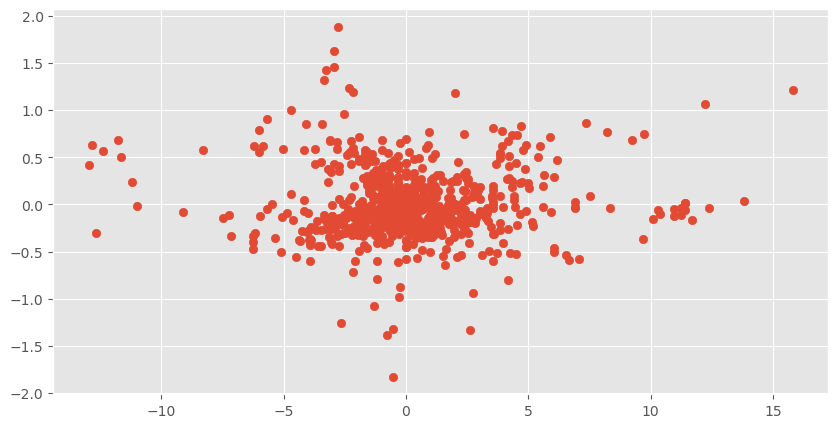

In [77]:
fig, axs = plt.subplots(figsize=(10,5))
axs.scatter(panel_t1[0]['Cum_Log_Return_VIX_Fut'], resid_t1['residual'])

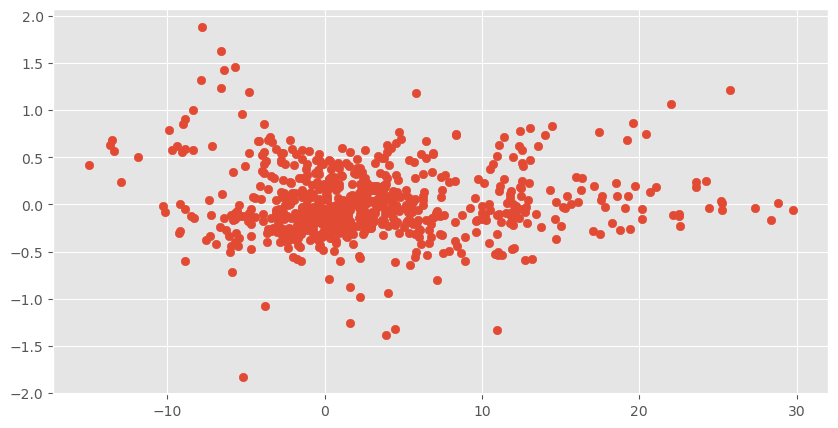

In [78]:
fig, axs = plt.subplots(figsize=(10,5))
axs.scatter(panel_t1[0]['Cum_Change_VIX'], resid_t1['residual'])

In [71]:
t2_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_t2[0]).fit(cov_type='clustered', clusters=panel_t2[1])
print(t2_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.7258
Estimator:                     PanelOLS   R-squared (Between):              0.7410
No. Observations:                   980   R-squared (Within):               0.5330
Date:                  Fri, Nov 01 2024   R-squared (Overall):              0.7258
Time:                          15:44:09   Log-likelihood                   -899.50
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      515.51
Entities:                            70   P-value                           0.0000
Avg Obs:                         14.000   Distribution:                   F(5,974)
Min Obs:                         14.000                                           
Max Obs:                         14.000   F-statistic (robust):             21.332
    

In [37]:
t3_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1+ Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_t3[0]).fit(cov_type='clustered', clusters=panel_t3[1])
print(t3_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.7242
Estimator:                     PanelOLS   R-squared (Between):              0.7374
No. Observations:                   560   R-squared (Within):               0.4795
Date:                  Sat, Oct 26 2024   R-squared (Overall):              0.7242
Time:                          23:31:31   Log-likelihood                   -469.86
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      290.93
Entities:                            70   P-value                           0.0000
Avg Obs:                         8.0000   Distribution:                   F(5,554)
Min Obs:                         8.0000                                           
Max Obs:                         8.0000   F-statistic (robust):             26.795
    

In [61]:
t4_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_t4[0]).fit(cov_type='clustered', clusters=panel_t4[1])
print(t4_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.7349
Estimator:                     PanelOLS   R-squared (Between):              0.7440
No. Observations:                   490   R-squared (Within):               0.4945
Date:                  Fri, Nov 01 2024   R-squared (Overall):              0.7349
Time:                          15:36:20   Log-likelihood                   -474.78
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      268.36
Entities:                            70   P-value                           0.0000
Avg Obs:                         7.0000   Distribution:                   F(5,484)
Min Obs:                         7.0000                                           
Max Obs:                         7.0000   F-statistic (robust):             23.550
    

### Overnight

In [32]:
o1_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_o1[0]).fit(cov_type='clustered', clusters=panel_o1[1])
print(o1_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.6357
Estimator:                     PanelOLS   R-squared (Between):              0.6565
No. Observations:                   140   R-squared (Within):               0.4885
Date:                  Mon, Oct 28 2024   R-squared (Overall):              0.6357
Time:                          11:30:29   Log-likelihood                   -0.7693
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      46.772
Entities:                            70   P-value                           0.0000
Avg Obs:                         2.0000   Distribution:                   F(5,134)
Min Obs:                         2.0000                                           
Max Obs:                         2.0000   F-statistic (robust):             134.43
    

In [33]:
o2_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_o2[0]).fit(cov_type='clustered', clusters=panel_o2[1])
print(o2_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.6261
Estimator:                     PanelOLS   R-squared (Between):              0.6366
No. Observations:                   140   R-squared (Within):               0.3028
Date:                  Mon, Oct 28 2024   R-squared (Overall):              0.6261
Time:                          11:31:28   Log-likelihood                   -108.50
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      44.882
Entities:                            70   P-value                           0.0000
Avg Obs:                         2.0000   Distribution:                   F(5,134)
Min Obs:                         2.0000                                           
Max Obs:                         2.0000   F-statistic (robust):             27.519
    

In [34]:
o3_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_o3[0]).fit(cov_type='clustered', clusters=panel_o3[1])
print(o3_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.7181
Estimator:                     PanelOLS   R-squared (Between):              0.7288
No. Observations:                   140   R-squared (Within):               0.1709
Date:                  Mon, Oct 28 2024   R-squared (Overall):              0.7181
Time:                          11:32:08   Log-likelihood                   -126.40
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      68.261
Entities:                            70   P-value                           0.0000
Avg Obs:                         2.0000   Distribution:                   F(5,134)
Min Obs:                         2.0000                                           
Max Obs:                         2.0000   F-statistic (robust):             41.647
    

## Sorting (2012-2021)

In [3]:
_1min_ret = pd.read_parquet('Data/spy_hyg_lqd_tlt_shy_1min_ret.parquet')

In [16]:
spy_1min = _1min_ret[_1min_ret['symbol'] == 'SPY'].reset_index(drop=True).set_index('datetime')

In [20]:
spy_1min.tail()

,symbol,midquote,bid,ask,ret
datetime,,,,,
2022-12-30 15:56:00,SPY,382.095,382.09,382.10,-0.000549
2022-12-30 15:57:00,SPY,382.215,382.21,382.22,0.000314
2022-12-30 15:58:00,SPY,382.195,382.19,382.20,-0.000052
2022-12-30 15:59:00,SPY,382.255,382.25,382.26,0.000157
2022-12-30 16:00:00,SPY,382.435,382.43,382.44,0.000471


In [19]:
spy_1min.between_time('16:01', '9:00')

,symbol,midquote,bid,ask,ret
datetime,,,,,
